In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, NumeralTickFormatter
from bokeh.transform import factor_cmap
from bokeh.palettes import Category10
from bokeh.io import output_notebook
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pytz
import ast
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

In [215]:
df = pd.read_csv('data_clean.csv')

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12895 entries, 0 to 12894
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           12895 non-null  int64  
 1   node_id                      12895 non-null  object 
 2   full_name                    12895 non-null  object 
 3   description                  12894 non-null  object 
 4   created_at                   12895 non-null  object 
 5   updated_at                   12895 non-null  object 
 6   pushed_at                    12895 non-null  object 
 7   size                         12895 non-null  int64  
 8   has_issues                   12895 non-null  bool   
 9   has_projects                 12895 non-null  bool   
 10  has_downloads                12895 non-null  bool   
 11  has_wiki                     12895 non-null  bool   
 12  has_pages                    12895 non-null  bool   
 13  has_discussions 

In [187]:
print(df)

              id       node_id                                      full_name  \
0      443592401  R_kgDOGnCu0Q                               progfolio/elpaca   
1      443476254  R_kgDOGm7pHg                         MoserMichael/pyasmtool   
2      443522708  R_kgDOGm-elA                victoryhb/streamlit-option-menu   
3      443522851  R_kgDOGm-fIw                                yihong0618/2022   
4      443529166  R_kgDOGm-3zg                        ice-doom/codeql_compile   
...          ...           ...                                            ...   
12890  654902184  R_kgDOJwkDqA                      ConnectAI-E/Go-Midjourney   
12891  654899923  R_kgDOJwj60w                    Implex-ltd/Implex-generator   
12892  654827428  R_kgDOJwffpA  supershaneski/openai-api-function-call-sample   
12893  655021349  R_kgDOJwrVJQ                             itrewm/Snapp-prize   
12894  654989401  R_kgDOJwpYWQ               zodiacon/winnativeapibooksamples   

                           

In [6]:
import pandas as pd

# Create a Series from the top_10_contributors column
contributors = df['top_10_contributors'].apply(pd.Series).stack().reset_index(level=1, drop=True)

# Get value counts of contributors
counts = contributors.value_counts() 

# Print top 20 contributors
print(counts.nlargest(20))

[]                     150
['PB2204']              12
['THARUN1526']          11
['daveshap']            10
['TheD1rkMtr']           9
['codewithsadee']        9
['bedimcode']            8
['crnacura']             7
['ErickWendel']          7
['dabit3']               6
['simonw']               6
['lucidrains']           6
['burpheart']            6
['cornflourblue']        5
['Anish-Agnihotri']      5
['dievus']               5
['bradtraversy']         5
['r00tSe7en']            5
['m1guelpf']             5
['geerlingguy']          4
Name: count, dtype: int64


### repo

In [188]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['updated_at'] = pd.to_datetime(df['updated_at'])
df['pushed_at'] = pd.to_datetime(df['pushed_at'])

In [189]:
df['month'] = df['created_at'].dt.month
projects_by_month = df.groupby('month')['id'].count()

In [190]:
# Création d'un DataFrame avec le nombre de projets créés par mois
df_projects_by_month = projects_by_month.reset_index()
df_projects_by_month.columns = ['Month', 'Number of Projects Created']

# Création du graphique en ligne à l'aide de Plotly
fig = px.line(df_projects_by_month, x='Month', y='Number of Projects Created', markers=True)

# Personnalisation de la mise en page du graphique
fig.update_layout(
    title='Tendances de la création de projets par mois',
    xaxis_title='Mois',
    yaxis_title='Number of Projects Created',
    xaxis={'type': 'category'},
    yaxis={'gridcolor': 'lightgray'},
    hovermode='x',
    legend={'orientation': 'h', 'y': -0.2},)

fig.show()

In [191]:
# Créer un DataFrame avec la taille moyenne des projets par mois
avg_size_by_month = df.groupby('month')['size'].mean()
df_avg_size_by_month = avg_size_by_month.reset_index()
df_avg_size_by_month.columns = ['Month', 'Average Project Size']

# Créer le graphique en ligne en utilisant Plotly
fig = px.line(df_avg_size_by_month, x='Month', y='Average Project Size', markers=True)

# Personnaliser la mise en page du graphique
fig.update_layout(
    title='Tendances de la taille moyenne des projets par mois',
    xaxis_title='Mois',
    yaxis_title='Taille moyenne du projet',
    xaxis={'type': 'category'},
    yaxis={'gridcolor': 'lightgray'},
    hovermode='x',
    legend={'orientation': 'h', 'y': -0.2},)
fig.show()

In [192]:
projects_updated_by_month = df.groupby('month')['updated_at'].count()
projects_pushed_by_month = df.groupby('month')['pushed_at'].count()

# Create a figure object
fig = go.Figure()

# Add the line trace for project updates
fig.add_trace(go.Scatter(
    x=projects_updated_by_month.index,
    y=projects_updated_by_month.values,
    name='Projects Updated',
    mode='lines',
    line=dict(color='blue')
))

# Add the line trace for project pushes
fig.add_trace(go.Scatter(
    x=projects_pushed_by_month.index,
    y=projects_pushed_by_month.values,
    name='Projects Pushed',
    mode='lines',
    line=dict(color='green')
))

# Customize the chart layout
fig.update_layout(
    title='Trends in Project Updates and Pushes by Month',
    xaxis_title='Month',
    yaxis_title='Number of Projects',
    xaxis={'type': 'category'},
    yaxis={'gridcolor': 'lightgray'},
    hovermode='x',
    legend={'orientation': 'h', 'y': -0.2},
)

# Show the chart
fig.show()


In [193]:
# Extraire l'année et le mois de la colonne 'created_at'
df['year_month'] = df['created_at'].dt.to_period('M')

# Regrouper les données par année et mois et calculer le nombre médian d'étoiles (stars), de forks et de watchers
median_stars_by_month = df.groupby('year_month')['star'].median()
median_forks_by_month = df.groupby('year_month')['forks'].median()
median_watchers_by_month = df.groupby('year_month')['watchers'].median()

# Configurer la figure
output_notebook()
p = figure(x_range=median_stars_by_month.index.astype(str).tolist(), plot_width=800, plot_height=400,
           title='Popularité des projets au fil du temps', x_axis_label='Année-Mois', y_axis_label='Nombre médian')

# Tracer le nombre médian d'étoiles, de forks et de watchers au fil du temps
p.line(median_stars_by_month.index.astype(str).tolist(), median_stars_by_month.values, legend_label='Étoiles', line_color='blue')
p.line(median_forks_by_month.index.astype(str).tolist(), median_forks_by_month.values, legend_label='Forks', line_color='green')
p.line(median_watchers_by_month.index.astype(str).tolist(), median_watchers_by_month.values, legend_label='Watchers', line_color='red')

# Formater les étiquettes des ticks de l'axe y en nombres entiers
p.yaxis.formatter = NumeralTickFormatter(format="0")

# Faire pivoter les étiquettes des ticks de l'axe x
p.xaxis.major_label_orientation = 45

# Afficher le graphique
show(p)


C:\Users\amine\AppData\Local\Temp\ipykernel_16468\2131798895.py:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



Loading BokehJS ...

In [194]:
# Get the current date with the appropriate timezone
current_date = datetime.now(pytz.utc)

# Calculate the age of open issues
df['issue_age'] = (current_date - df['created_at']).dt.days

# Analyze frequency of updates
df['update_frequency'] = (df['updated_at'] - df['created_at']).dt.days

# Analyze activity by pushes
df['push_activity'] = (df['updated_at'] - df['pushed_at']).dt.days

# Print the analysis results
print("Age of Open Issues:")
print(df['issue_age'].describe().round(2))
print()

print("Frequency of Updates:")
print(df['update_frequency'].describe().round(2))
print()

print("Activity by Pushes:")
print(df['push_activity'].describe().round(2))


Age of Open Issues:
count    12895.00
mean       279.66
std        172.07
min         24.00
25%        124.00
50%        251.00
75%        435.00
max        557.00
Name: issue_age, dtype: float64

Frequency of Updates:
count    12895.00
mean       255.78
std        166.62
min          0.00
25%        108.00
50%        231.00
75%        410.00
max        545.00
Name: update_frequency, dtype: float64

Activity by Pushes:
count    12895.00
mean        93.31
std        123.22
min       -218.00
25%          6.00
50%         42.00
75%        132.00
max        539.00
Name: push_activity, dtype: float64


In [195]:
contrib_df = df[['full_name', 'top_10_contributors']].explode('top_10_contributors')
top_contrib_df = contrib_df.groupby('full_name').count().sort_values(by='top_10_contributors', ascending=False).head(20)
top_contrib_repos = top_contrib_df.index.tolist()

In [196]:

# Convert string representations of dictionaries to actual dictionaries
df['contributors'] = df['contributors'].apply(ast.literal_eval)

# Calculate the total contributions for each repository
df['Total Contributions'] = df['contributors'].apply(lambda x: sum([contrib['contributions'] for contrib in x]))

# Sort the DataFrame based on total contributions in descending order
df_sorted_by_contributions = df.sort_values('Total Contributions', ascending=False)

# Select the top 20 repositories
top_20_repos = df_sorted_by_contributions.head(20)

# Print the top 20 repositories
print("Top 20 Repositories based on Total Contributions:")
print(top_20_repos[['full_name', 'Total Contributions']])


Top 20 Repositories based on Total Contributions:
                                    full_name  Total Contributions
5490                    arielherself/espresso                12144
694                    proxmox/proxmox-backup                 6696
10220                     vfarid/cf-clean-ips                 6624
7362     7oSkaaa/LeetCode_DailyChallenge_2023                 6090
7627                     cuixiaorui/VSCodeVim                 5867
7775                         buroa/k8s-gitops                 5265
2747                        szinn/k8s-homelab                 4188
2410   perpetual-protocol/perp-curie-contract                 3327
305                     NickvisionApps/Denaro                 3065
3639                         Gh0stBlade/KAIN2                 2929
5742                       codinasion/program                 2732
7958                    gngpp/Actions-OpenWrt                 2722
3466        matterandvoid-space/subscriptions                 2628
6874        

In [197]:
# Création d'un graphique à barres
fig = go.Figure(data=go.Bar(
    x=top_20_repos['Total Contributions'],
    y=top_20_repos['full_name'],
    orientation='h',
    marker_color='blue'
))

# Personnalisation de la mise en page
fig.update_layout(
    title='Top 20 des dépôts basés sur les contributions totales',
    xaxis_title='Contributions totales',
    yaxis_title='Dépôt',
    yaxis_autorange='reversed'
)

fig.show()


#### statistiques descriptives

In [198]:
selected_columns = ['size', 'open_issues', 'star', 'watchers', 'forks']
stats = df[selected_columns].describe().round(2)
stats

size  open_issues      star  watchers     forks
count  12895.00     12895.00  12895.00  12895.00  12895.00
mean    3125.69         2.45     90.80      3.98     15.51
std     5222.59         3.30     66.74      2.76     49.07
min        0.00         0.00     10.00      0.00      0.00
25%      131.00         0.00     46.00      2.00      3.00
50%      679.00         1.00     68.00      3.00      7.00
75%     3430.00         4.00    115.00      5.00     16.00
max    25641.00        15.00    349.00     14.00   2636.00

### size

In [199]:
# Analyse de distribution - Histogramme
fig = px.histogram(df, x='size', nbins=20, color_discrete_sequence=['#008080'])
fig.update_layout(
    xaxis_title='Taille',
    yaxis_title='Fréquence',
    title='Distribution des tailles de projet',
    plot_bgcolor='white',
    paper_bgcolor='white'
)
fig.show()

# Analyse de séries temporelles - Graphique linéaire
df['created_at'] = pd.to_datetime(df['created_at'])  # Convert to datetime if necessary
df_sorted = df.sort_values('created_at')  # Sort by creation date
fig = px.line(df_sorted, x='created_at', y='size', color_discrete_sequence=['#800080'])
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Taille',
    title='Évolution des tailles de projet au fil du temps',
    plot_bgcolor='white',
    paper_bgcolor='white'
)
fig.show()


In [200]:
# Définir les limites des intervalles et les étiquettes pour les catégories
bin_edges = [0, 500, 1000, 5000, float('inf')]
bin_labels = ['Petit', 'Moyen', 'Grand', 'Très grand']

# Créer une nouvelle colonne 'size_category' basée sur la colonne 'size'
df['size_category'] = pd.cut(df['size'], bins=bin_edges, labels=bin_labels, right=False)


In [201]:
# Compter le nombre d'occurrences de chaque catégorie dans la colonne 'size_category'
category_counts = df['size_category'].value_counts()

# Afficher le décompte des catégories
print(category_counts)


size_category
Petit         5836
Grand         3091
Très grand    2569
Moyen         1399
Name: count, dtype: int64


In [202]:
# Préparer les données
data = {
    'size_category': ['Small', 'Large', 'Very Large', 'Medium'],
    'count': [1900, 1181, 983, 536]
}

# Calculer le pourcentage pour chaque catégorie
total_count = sum(data['count'])
data['percentage'] = [count / total_count * 100 for count in data['count']]

# Créer un diagramme circulaire avec Plotly
fig = px.pie(data, values='count', names='size_category', 
             title='Catégories de taille des dépôts',
             labels={'count': 'Nombre', 'size_category': 'Catégorie de taille'},
             hover_data=['percentage'], 
             hover_name='size_category',
             hole=0.4)

# Définir le format du pourcentage pour l'étiquette au survol
fig.update_traces(textinfo='percent+label')

# Afficher le graphique
fig.show()


#### open_issues

In [203]:
# Créer l'histogramme de la distribution des open_issues
fig = px.histogram(df, x='open_issues', nbins=20)

# Personnaliser les titres des axes et le titre du graphique
fig.update_layout(
    xaxis_title='Open Issues',
    yaxis_title='Fréquence',
    title='Distribution des Open Issues'
)

# Afficher le graphique
fig.show()


In [204]:
# Convertir la colonne "created_at" en datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Regrouper les données par date et compter le nombre de open_issues pour chaque date
trend_data = df.groupby(df['created_at'].dt.date)['open_issues'].count()

# Créer une figure Bokeh
output_notebook()  # Afficher le graphique dans Jupyter Notebook
p = figure(title='Analyse de tendance des Open Issues', x_axis_type='datetime', sizing_mode='stretch_both',
           background_fill_color='#f2f2f2', tools='hover')

# Tracer la ligne de tendance
p.line(trend_data.index, trend_data.values, line_width=2, color='#007bff', legend_label='Open Issues')
p.circle(trend_data.index, trend_data.values, size=6, color='#007bff', alpha=0.8, legend_label='Open Issues')

# Personnaliser le graphique
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Nombre de Open Issues'
p.xaxis.formatter.days = '%m/%d/%Y'  # Formater les étiquettes de l'axe x
p.yaxis.formatter = NumeralTickFormatter(format='0')  # Formater les étiquettes de l'axe y en entiers
p.legend.location = 'top_left'
p.legend.label_text_font_size = '12px'

# Appliquer des aspects esthétiques supplémentaires
p.toolbar.logo = None
p.grid.grid_line_alpha = 0.3 
p.border_fill_color = '#ffffff' 

# Afficher le graphique
show(p)


Loading BokehJS ...

In [205]:
category_counts = {}

# Define your keywords and corresponding categories
keywords = {
    'bug': 'Bug',
    'error': 'Error',
    'issue': 'Issue',
    'crash': 'Crash',
    'failure': 'Failure'
    # Add more keywords and categories as needed
}

for index, row in df.iterrows():
    description = row['description']
    
    if isinstance(description, float):  # Check if description is a float
        description = str(description)  # Convert float to string
    
    description = description.lower()
    
    category = 'Non_classé'
    for keyword, cat in keywords.items():
        if keyword in description:
            category = cat
            break
    
    # Count the occurrences of each category
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Display the result for each category
for category, count in category_counts.items():
    print(f"{category}: {count}")


Non_classé: 12744
Bug: 73
Error: 38
Issue: 23
Crash: 13
Failure: 4


In [206]:
import pandas as pd
import plotly.graph_objects as go

# Define the category counts
category_counts = {
    'Non_classé': 12744,
    'Bug': 73,
    'Error': 38,
    'Issue': 23,
    'Crash': 13,
    'Failure': 4
}

category_colors = {
    'Bug': 'lightblue',
    'Error': 'lightgreen',
    'Crash': 'lightyellow',
    'Failure': 'lightcoral'
}

default_color = 'gray'  # Define a default color for categories not in category_colors

# Create the DataFrame for category counts
df_counts = pd.DataFrame({'category': list(category_counts.keys()), 'count': list(category_counts.values())})

# Filter out the 'Non_classé' category
df_filtered = df_counts[df_counts['category'] != 'Non_classé']

# Create the bar chart
fig = go.Figure(data=[go.Bar(
    x=df_filtered['category'],
    y=df_filtered['count'],
    marker_color=[category_colors.get(cat, default_color) for cat in df_filtered['category']]
)])

# Customize the layout
fig.update_layout(
    title='Category Counts for Problems',
    xaxis_title='Category',
    yaxis_title='Count',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font_color='black'
)

# Show the chart
fig.show()


#### watchers

In [207]:
# Analyse de la distribution - Histogramme des Watchers
fig_histogram = px.histogram(df, x='watchers', nbins=20)
fig_histogram.update_layout(
    xaxis_title='Nombre de Watchers',
    yaxis_title='Fréquence',
    title='Distribution des Watchers'
)
fig_histogram.show()

# Analyse de séries temporelles - Graphique en ligne des Watchers
df['created_at'] = pd.to_datetime(df['created_at'])  # Conversion en format datetime si nécessaire
df_sorted = df.sort_values('created_at')  # Trier par date de création
fig_line = px.line(df_sorted, x='created_at', y='watchers')
fig_line.update_layout(
    xaxis_title='Date',
    yaxis_title='Nombre de Watchers',
    title='Évolution des Watchers au fil du temps'
)
fig_line.show()


In [208]:
fig = px.scatter(df, x='star', y='watchers', title='Stars vs. Watchers')
fig.update_layout(xaxis_title='Star', yaxis_title='Watchers')
fig.show()


### corrélation

In [209]:
# Sélectionner les colonnes numériques pour l'analyse de corrélation
numerical_columns = ['size', 'open_issues', 'star', 'watchers', 'forks']
numerical_df = df[numerical_columns]

# Calculer la matrice de corrélation
correlation_matrix = numerical_df.corr()

# Afficher la matrice de corrélation
print(correlation_matrix)


                 size  open_issues      star  watchers     forks
size         1.000000     0.070241  0.045059  0.067689  0.019901
open_issues  0.070241     1.000000  0.211716  0.214791  0.056987
star         0.045059     0.211716  1.000000  0.380878  0.178616
watchers     0.067689     0.214791  0.380878  1.000000  0.109431
forks        0.019901     0.056987  0.178616  0.109431  1.000000


In [210]:
# Sélectionner les colonnes numériques pour l'analyse de corrélation
numerical_columns = ['size', 'open_issues', 'star', 'watchers', 'forks']
numerical_df = df[numerical_columns]

# Calculer la matrice de corrélation
correlation_matrix = numerical_df.corr()

# Créer une heatmap avec Plotly
fig = px.imshow(correlation_matrix,
                x=numerical_columns,
                y=numerical_columns,
                color_continuous_scale='RdBu',
                zmin=-1,
                zmax=1)

# Personnaliser la mise en page de la heatmap
fig.update_layout(
    title='Matrice de corrélation',
    xaxis=dict(title='Variables'),
    yaxis=dict(title='Variables'),
    width=600,
    height=500
)

# Afficher la heatmap
fig.show()


#### contributors

In [218]:
# Replace single quotes with double quotes in the contributors column
df['contributors'] = df['contributors'].str.replace("'", "\"")

# Extract the total number of contributions made by each contributor
contributors = {}
for row in df.itertuples():
    for c in eval(row.contributors):
        if c['login'] in contributors:
            contributors[c['login']] += c['contributions']
        else:
            contributors[c['login']] = c['contributions']
df_contributions = pd.DataFrame(list(contributors.items()), columns=['username', 'total_contributions'])

In [159]:
df_top_contributors.sort_values(by=['total_contributions'], ascending=False).head(10)

username  total_contributions
197        dependabot[bot]                15827
14461         arielherself                12144
324          renovate[bot]                11704
23739               vfarid                 6620
11     github-actions[bot]                 3719
18806              7oSkaaa                 3599
2042         maurerdietmar                 2974
10120           Gh0stBlade                 2754
7883      repo-jeeves[bot]                 2660
1093          actions-user                 2544

In [113]:
# Create bins for the number of contributions
bins = [0, 10, 50, 100, 500, 1000, 5000, 10000, float('inf')]
labels = ['<10', '10-50', '50-100', '100-500', '500-1000', '1000-5000', '5000-10000', '>10000']
df_contributions['activity_level'] = pd.cut(df_contributions['total_contributions'], bins=bins, labels=labels)

# Group contributors by activity level and calculate the number of contributors in each group
df_activity = df_contributions.groupby('activity_level').agg(num_contributors=('username', 'count'))

print(df_activity)

                num_contributors
activity_level                  
<10                        17009
10-50                       6373
50-100                      2211
100-500                     2385
500-1000                     203
1000-5000                     73
5000-10000                     1
>10000                         3


In [219]:
# Calculate the percentage of contributions made by the top 10 contributors
num_contributions_top = df_top_contributors.head(10)['total_contributions'].sum()
num_contributions_total = df_contributions['total_contributions'].sum()
percent_contributions_top = num_contributions_top / num_contributions_total * 100

percent_contributions_top.round(2)

5.61

In [221]:
# Préparer les données
data = {
    'size_category': ['<10', '10-50', '50-100', '100-500', '500-1000', '1000-5000', '5000-10000', '>10000'],
    'count': [17009, 6373, 2211, 2385, 203, 73, 1, 3]
}

# Calculer le pourcentage pour chaque catégorie de contributeur
total_count = sum(data['count'])
data['percentage'] = [count / total_count * 100 for count in data['count']]

# Créer un diagramme circulaire avec Plotly
fig = px.pie(data, values='count', names='size_category', 
             title='Contributeurs',
             labels={'count': 'Nombre', 'size_category': 'Catégorie de taille'},
             hover_data=['percentage'], 
             hover_name='size_category',
             hole=0.4)

# Définir le format du pourcentage pour l'étiquette au survol
fig.update_traces(textinfo='percent+label')

# Afficher le graphique
fig.show()


In [222]:
contributors = df_top_contributors.sort_values(by=['total_contributions'], ascending=False).head(10)
contributions = contributors['total_contributions'].values.tolist()

# Créer une ColumnDataSource avec les données
data = {
    'contributors': contributors['username'].values.tolist(),
    'contributions': contributions,
    'color': Category10[10][:len(contributors)]
}
source = ColumnDataSource(data=data)

output_notebook()

# Créer la figure
p = figure(x_range=contributors['username'].values.tolist(), plot_height=400, title="Top 10 contributeurs",
           toolbar_location=None, tools="")

# Ajouter les barres au graphique
p.vbar(x='contributors', top='contributions', width=0.9, color='color', legend_field='contributors',
       source=source)

# Configurer le graphique
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.xaxis.major_label_orientation = 1.2
p.xaxis.axis_label = 'Contributors'
p.yaxis.axis_label = 'Total Contributions'
p.title.align = 'center'
p.title.text_font_size = '18pt'
p.xaxis.major_label_text_font_size = '14pt'
p.yaxis.major_label_text_font_size = '14pt'
p.xaxis.axis_label_text_font_size = '16pt'
p.yaxis.axis_label_text_font_size = '16pt'

# Afficher le graphique
show(p)

Loading BokehJS ...

### langues

In [223]:
language_names = df['language_name']
language_percentages = df['language_percent']


In [224]:
language_frequencies = {}

for names, percentages in zip(language_names, language_percentages):
    for name, percentage in zip(names, percentages):
        if name in language_frequencies:
            language_frequencies[name] += percentage
        else:
            language_frequencies[name] = percentage


In [225]:
sorted_languages = sorted(language_frequencies.items(), key=lambda x: x[1], reverse=True)

In [226]:
df['language_name'] = df['language_name'].apply(ast.literal_eval)

In [227]:
df = df.explode('language_name')

In [228]:
projects_by_language = df['language_name'].value_counts()

In [229]:
non_language_programming = ['Makefile', 'Dockerfile', 'Jupyter Notebook', 'Batchfile', 'Procfile', 'Vim Script', 'Nix', 'GLSL', 'Emacs Lisp', 'Roff', 'NSIS', 'AutoHotkey', 'Gnuplot', 'Logos', 'Markdown', 'Lex', 'NASL', 'Rich Text Format', 'TeX', 'Racket', 'XS', 'Bicep', 'AppleScript', 'VBA', 'ASP.NET', 'CodeQL', 'Cap\'n Proto', 'ShaderLab', 'HLSL', 'Rebol', 'mcfunction', 'G-code', 'VHDL', 'SQL', 'AWK', 'PLpgSQL', 'ReScript', 'MDX', 'Verilog', 'POV-Ray SDL', 'Jasmin', 'Cypher', 'StringTemplate', 'POV-Ray SDL', 'WebAssembly', 'Portugol', 'RPC', 'AngelScript', 'ASN.1', 'POV-Ray SDL', 'Latte', 'Stan', 'Cypher Query Language', 'XS', 'Starlark']

In [230]:
filtered_df = df[~df['language_name'].apply(lambda x: any(keyword in x for keyword in non_language_programming))]

# Perform analysis on the filtered dataframe
# For example, count the occurrences of each programming language
language_counts = filtered_df['language_name'].explode().value_counts()

# Print the language counts
print(language_counts)


language_name
Python                      4291
JavaScript                  3487
Shell                       3045
HTML                        2429
TypeScript                  2146
                            ... 
Sieve                          1
MLIR                           1
DIGITAL Command Language       1
Objective-J                    1
sed                            1
Name: count, Length: 184, dtype: int64


In [231]:
import plotly.express as px

# Sort the language counts in descending order
sorted_language_counts = language_counts.sort_values(ascending=False)

# Select the top 20 languages
top_20_languages = sorted_language_counts.head(20)

# Create a bar chart using Plotly
fig = px.bar(x=top_20_languages.index, y=top_20_languages.values)
fig.update_layout(
    xaxis_title='Programming Language',
    yaxis_title='Number of Occurrences',
    title='Top 20 Programming Languages by Occurrences (Excluding Non-language Programming)',
    xaxis_tickangle=-45
)
fig.show()


### relations

In [232]:
# Choose a project for comparison
chosen_project = "progfolio/elpaca"

# Get the index of the chosen project
chosen_project_index = df[df['full_name'] == chosen_project].index[0]

# Calculate cosine similarity scores for the chosen project
cosine_similarities = cosine_similarity(tfidf_matrix[chosen_project_index], tfidf_matrix).flatten()

# Sort projects based on similarity scores
similar_projects_indices = cosine_similarities.argsort()[::-1][1:]  # Exclude the chosen project itself

# Get top similar projects (e.g., top 5)
top_k = 5
top_similar_projects = df.loc[similar_projects_indices[:top_k], 'full_name']

# Print the top similar projects
print(f"Top {top_k} similar projects to {chosen_project}:")
for i, project in enumerate(top_similar_projects, start=1):
    print(f"{i}. {project}")


NameError: name 'tfidf_matrix' is not defined

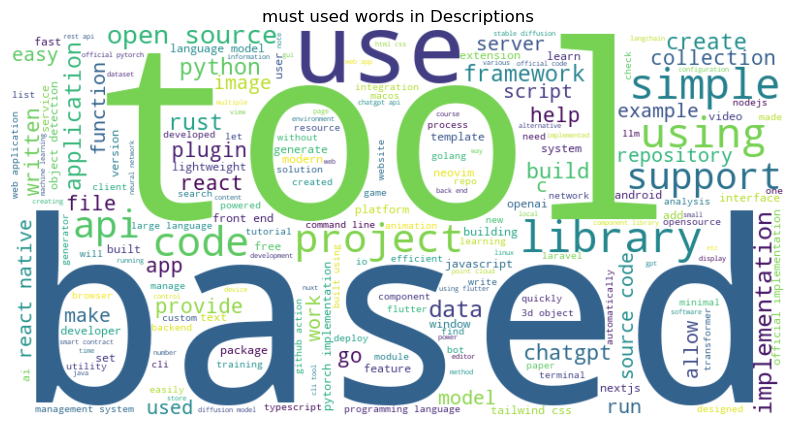

In [233]:
# Generate a word cloud based on the descriptions of repositories
from wordcloud import WordCloud

# Concatenate all descriptions into a single string
descriptions = ' '.join(df['description'].dropna().astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(descriptions)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('must used words in Descriptions')
plt.show()

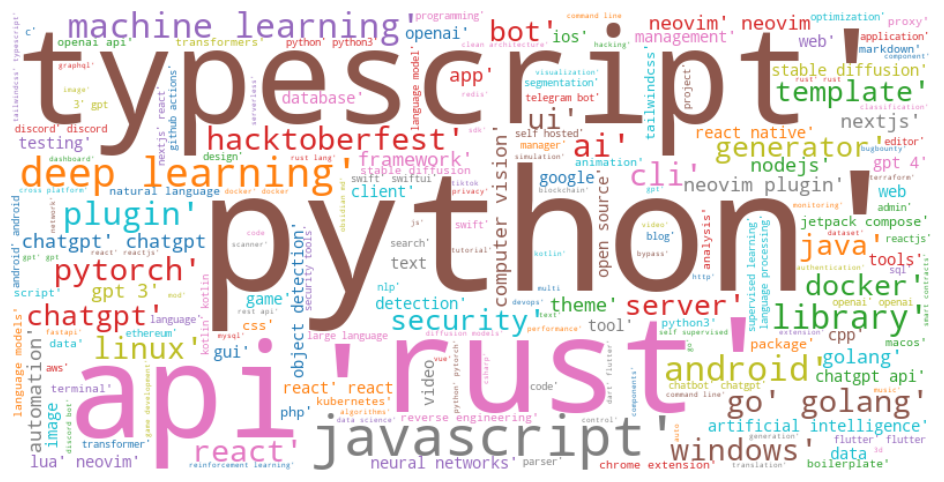

In [130]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all topics into a single string, excluding the word "exclu"
all_topics = ' '.join([topic for topic in df['topics'].astype(str).tolist() if 'without topic' not in topic])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab10').generate(all_topics)

# Display the generated image
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [236]:
df['primary_language'] = df['language_name'].apply(lambda x: x.split(',')[0].strip())
criteria = ['forks', 'star', 'watchers', 'size']
top_repos = df.nlargest(100, criteria)

In [237]:
analyzer = SentimentIntensityAnalyzer()
top_repos['sentiment'] = top_repos['description'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
top_repos['sentiment_label'] = top_repos['sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')
workflow_counts = top_repos[workflows].sum()

In [238]:
# Create a bar chart of the workflow_counts data
fig = go.Figure([go.Bar(x=workflow_counts.index, y=workflow_counts.values, marker_color='#1f77b4')])

# Customize the appearance of the chart
fig.update_layout(title='Usage of Development Workflows', xaxis_title='Workflow', yaxis_title='Count', 
                  font=dict(family='Arial', size=14), title_font=dict(size=18),
                  margin=dict(l=50, r=50, t=80, b=50), plot_bgcolor='rgba(0, 0, 0, 0)')

# Display the chart
fig.show()

In [239]:
print('The top programming languages used in the most successful repositories are:')
print(top_repos['primary_language'].value_counts().head())

The top programming languages used in the most successful repositories are:
primary_language
Python        12
JavaScript    10
Dockerfile    10
Shell          8
HTML           7
Name: count, dtype: int64


In [240]:
print('The most common development workflows used in the most successful repositories are:')
print(workflow_counts)

The most common development workflows used in the most successful repositories are:
has_issues      84
has_projects    68
has_wiki        66
has_pages       13
archived        22
disabled         0
dtype: int64


In [241]:
tfidf = TfidfVectorizer(stop_words='english')
doc_term_matrix = tfidf.fit_transform(top_repos['description'].values.astype('U'))
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(doc_term_matrix)
for index, topic in enumerate(lda.components_):
    print(f'Top 10 words for topic #{index}:')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['youtube', 'deks', 'tutorial', 'ini', 'isi', 'pemasangan', 'dan', 'frontend', 'practices', 'repository']


Top 10 words for topic #1:
['fɪʟᴛᴇʀ', 'vps', 'heroku', 'simple', 'bᴏᴛ', 'supports', 'aᴜᴛᴏ', 'powerful', 'mogenius', 'koyeb']


Top 10 words for topic #2:
['support', 'telegram', 'opensource', 'programming', 'solutions', 'codebase', 'collection', 'issue', 'sharing', 'good']


Top 10 words for topic #3:
['deploy', 'okteto', 'cloud', 'nodes', 'container', 'xray', 'build', 'openwrt', 'firmware', 'glinet']


Top 10 words for topic #4:
['opensource', 'ui', 'tailwind', 'tailwindcss', 'soft', 'free', 'dashboard', 'source', 'officially', 'vmprotect']




C:\Users\amine\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



### recommandation

#### Utiliser des langages de programmation populaires et largement utilisés tels que Python et JavaScript Mettre en œuvre des workflows de développement qui incluent le suivi des problèmes, la gestion de projet et les wikis Se concentrer sur des sujets et des thèmes pertinents et importants pour le public cible du référentiel Collaborer avec d'autres développeurs et contributeurs pour améliorer la qualité et l'efficacité du code et de la documentation du référentiel.